In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , RandomizedSearchCV , GridSearchCV 
from sklearn.metrics import r2_score , mean_squared_error
import xgboost as xgb
import lightgbm as lgbm


In [43]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [44]:
df_train.isnull().sum()

Id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [45]:
df_train.duplicated().sum()

0

In [46]:
# selected_features = ['alcohol' , 'sulphates' , 'citric acid' ,'fixed acidity' , 'total sulfur dioxide' , 'density']
# selected_features = ['alcohol' , 'sulphates', 'total sulfur dioxide']
# selected_features = ['alcohol' , 'sulphates', 'total sulfur dioxide', 'volatile acidity' , 'citric acid', 'density' , 'fixed acidity']
selected_features = ['alcohol' , 'sulphates', 'total sulfur dioxide', 'volatile acidity' , 'citric acid']



In [47]:
selected_features

['alcohol',
 'sulphates',
 'total sulfur dioxide',
 'volatile acidity',
 'citric acid']

In [48]:
X =  df_train[selected_features]
y = df_train.quality
test  = df_test[selected_features]

In [49]:
X.skew()

alcohol                 0.786872
sulphates               1.802854
total sulfur dioxide    1.267906
volatile acidity        0.668343
citric acid             0.246571
dtype: float64

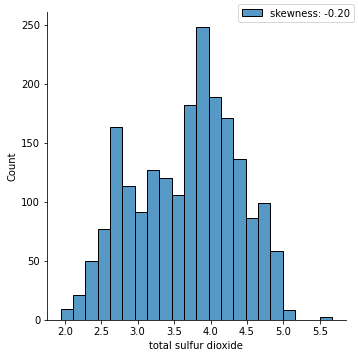

In [50]:
#by using log transformation
import matplotlib.pyplot as plt
import seaborn as sns
Log_sul = X["total sulfur dioxide"].map(lambda i: np.log(i) if i > 0 else 0)
sul_plot = sns.displot(Log_sul , label = "skewness: %.2f"%(Log_sul.skew()))
sul_plot.figure.legend()
# plt.show()



In [51]:
Log_sul.skew()

-0.200689213452749

In [52]:
from scipy import stats

from scipy import stats
Boxcox_suplhates = X["sulphates"].map(lambda i: np.abs(i) if i < 0 else (i+1 if i==0 else i))
Boxcox_suplhates= stats.boxcox(Boxcox_suplhates)
Boxcox_suplhates= pd.Series(Boxcox_suplhates[0])
X["sulphates"] = Boxcox_suplhates.values
# t=sns.displot(Boxcox_Fare,label="Skewness: %.2f"%(Boxcox_Fare.skew()) )
# t.figure.legend()

C:\Users\XAN\AppData\Local\Temp\ipykernel_17076\2647049826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["sulphates"] = Boxcox_suplhates.values


In [53]:
Boxcox_suplhates.skew()

0.00505746947083881

In [54]:
Boxcox_total_suplur = X["total sulfur dioxide"].map(lambda i: np.abs(i) if i < 0 else (i+1 if i==0 else i))
Boxcox_total_suplur= stats.boxcox(Boxcox_total_suplur)
Boxcox_total_suplur= pd.Series(Boxcox_total_suplur[0])
X["total sulfur dioxide"] = Boxcox_total_suplur.values

C:\Users\XAN\AppData\Local\Temp\ipykernel_17076\4147231863.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["total sulfur dioxide"] = Boxcox_total_suplur.values


In [55]:
Boxcox_total_suplur.skew()

-0.027045077817465353

In [56]:
X.skew()

alcohol                 0.786872
sulphates               0.005057
total sulfur dioxide   -0.027045
volatile acidity        0.668343
citric acid             0.246571
dtype: float64

In [57]:
X.skew()

alcohol                 0.786872
sulphates               0.005057
total sulfur dioxide   -0.027045
volatile acidity        0.668343
citric acid             0.246571
dtype: float64

In [58]:
# using Z-score
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_zscore(X["alcohol"])
print("Outliers from Z-scores method: ", sample_outliers)

Outliers from Z-scores method:  [13.6, 14.0, 14.0, 13.6, 13.6, 13.6, 13.566666666666698, 14.0, 13.6]


In [59]:
# using IRQ
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_iqr(X["alcohol"])
print("Outliers from IQR method: ", sample_outliers)

Outliers from IQR method:  [13.3, 13.3, 13.4, 13.4, 13.566666666666698, 13.6, 13.6, 13.6, 13.6, 13.6, 14.0, 14.0, 14.0]


Text(0.5, 0, 'Sample')

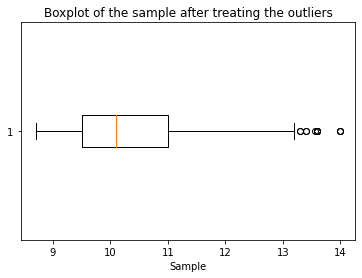

In [60]:
plt.boxplot(X["alcohol"], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

In [61]:
median = np.median(X["alcohol"])# Replace with median
for i in sample_outliers:
    c = np.where(X["alcohol"]==i, 10.1, X["alcohol"])
# print("Sample: ", sample_outliers)

print("New array: ",c)


New array:  [12.1 12.8 11.3 ... 12.5  9.5 11.4]


In [62]:
newalcohol = pd.DataFrame(c)

In [63]:
newalcohol

,0
0,12.1
1,12.8
2,11.3
3,9.8
4,9.5
...,...
2051,12.0
2052,9.4
2053,12.5
2054,9.5


Text(0.5, 0, 'Sample')

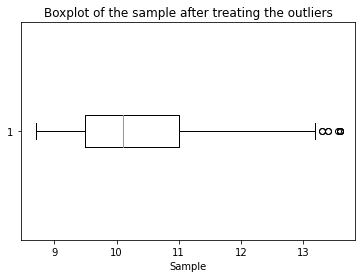

In [64]:
plt.boxplot(c, vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

In [65]:
X["alcohol"] = newalcohol

C:\Users\XAN\AppData\Local\Temp\ipykernel_17076\543054080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["alcohol"] = newalcohol


In [66]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_iqr(c)
print("Outliers from IQR method: ", sample_outliers)

Outliers from IQR method:  [13.3, 13.3, 13.4, 13.4, 13.566666666666698, 13.6, 13.6, 13.6, 13.6, 13.6]


Text(0.5, 0, 'Sample')

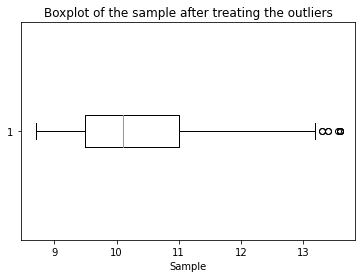

In [67]:
plt.boxplot(X["alcohol"], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

In [68]:
X.alcohol.describe()

count    2056.000000
mean       10.409282
std         1.019721
min         8.700000
25%         9.500000
50%        10.100000
75%        11.000000
max        13.600000
Name: alcohol, dtype: float64

In [69]:
df_test.head(1)

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.51,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8


In [70]:
model = xgb.XGBRegressor(
    base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None
)

In [71]:
model2 = lgbm.LGBMRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
            eval_metric=None, feature_types=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)

In [72]:

Xtrain , Xtest , ytrain , ytest = train_test_split(X, y , test_size=0.2 , random_state=0 )

In [73]:
Xtrain.skew()

alcohol                 0.782226
sulphates              -0.013750
total sulfur dioxide   -0.070054
volatile acidity        0.734631
citric acid             0.236747
dtype: float64

In [88]:
model.fit(Xtrain , ytrain)
y_pred = model.predict(Xtest)
score = mean_squared_error(ytest , y_pred)
print("the mse score is :" , score)



the mse score is : 0.5205221891230463


In [92]:
model2.fit(X , y)
y_pred2 = model2.predict(X)
score2 = mean_squared_error(y , y_pred2)
print("the r2_score  is :" , score2)



the r2_score  is : 0.344876730781812


In [93]:
ans = model2.predict(test)

In [94]:
ans = (np.rint(ans)).astype(int)

In [96]:
ans

array([5, 6, 5, ..., 5, 5, 6])

In [97]:
result = pd.DataFrame({'Id':df_test.Id , 'quality':ans})

In [80]:
result.to_csv('submission_lgbm.csv' ,index=False)

In [81]:
!pip install lightgbm


[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: C:\Users\XAN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
